In [2]:
import pandas as pd

# Data Loading

In [22]:
columns_needed = ["SUBJECT_ID", "CHARTTIME", "ITEMID","VALUENUM"]

# Read only necessary columns from CHARTEVENTS
chartevents= pd.read_csv("data/CHARTEVENTS.csv.gz", usecols=columns_needed, parse_dates=["CHARTTIME"], nrows=4000000) #you can change the nrows value here, i kept it short for shorter calculation time
print(chartevents.head())




   SUBJECT_ID  ITEMID           CHARTTIME  VALUENUM
0          36  223834 2134-05-12 12:00:00     15.00
1          36  223835 2134-05-12 12:00:00    100.00
2          36  224328 2134-05-12 12:00:00      0.37
3          36  224329 2134-05-12 12:00:00      6.00
4          36  224330 2134-05-12 12:00:00      2.50


In [ ]:
labevents = pd.read_csv("data/LABEVENTS.csv.gz", low_memory=False)
labevents.head()

In [5]:
icustays = pd.read_csv("data/ICUSTAYS.csv.gz")
icustays.head()


,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS
0,365,268,110404,280836,carevue,MICU,MICU,52,52,2198-02-14 23:27:38,2198-02-18 05:26:11,3.2490
1,366,269,106296,206613,carevue,MICU,MICU,52,52,2170-11-05 11:05:29,2170-11-08 17:46:57,3.2788
2,367,270,188028,220345,carevue,CCU,CCU,57,57,2128-06-24 15:05:20,2128-06-27 12:32:29,2.8939
3,368,271,173727,249196,carevue,MICU,SICU,52,23,2120-08-07 23:12:42,2120-08-10 00:39:04,2.0600
4,369,272,164716,210407,carevue,CCU,CCU,57,57,2186-12-25 21:08:04,2186-12-27 12:01:13,1.6202


In [6]:
diagnoses = pd.read_csv("data/DIAGNOSES_ICD.csv.gz")
diagnoses.head()


,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,1297,109,172335,1.0,40301
1,1298,109,172335,2.0,486
2,1299,109,172335,3.0,58281
3,1300,109,172335,4.0,5855
4,1301,109,172335,5.0,4254


In [ ]:
d_items = pd.read_csv("data/D_ITEMS.csv.gz")
d_items.head()


,ROW_ID,ITEMID,LABEL,ABBREVIATION,DBSOURCE,LINKSTO,CATEGORY,UNITNAME,PARAM_TYPE,CONCEPTID
0,457,497,Patient controlled analgesia (PCA) [Inject],NaN,carevue,chartevents,NaN,NaN,NaN,NaN
1,458,498,PCA Lockout (Min),NaN,carevue,chartevents,NaN,NaN,NaN,NaN
2,459,499,PCA Medication,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
3,460,500,PCA Total Dose,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
4,461,501,PCV Exh Vt (Obser),NaN,carevue,chartevents,NaN,NaN,NaN,NaN


# Data Processing and feature extraction

Search for important vital's itemids

In [13]:
chartevent_items = d_items[d_items['LINKSTO'] == 'chartevents']

def find_item(label_keyword):
    return chartevent_items[chartevent_items['LABEL'].str.contains(label_keyword, case=False, na=False)][['ITEMID', 'LABEL']]



In [14]:
# Look for common vital signs
print(find_item("heart rate"))
print(find_item("blood pressure"))
print(find_item("respiratory rate"))
print(find_item("spo2"))
print(find_item("temperature"))

       ITEMID                    LABEL
475       211               Heart Rate
1897     3494        Lowest Heart Rate
11498  220045               Heart Rate
11499  220046  Heart rate Alarm - High
11500  220047   Heart Rate Alarm - Low
       ITEMID                                     LABEL
9314   224167       Manual Blood Pressure Systolic Left
9441   227242     Manual Blood Pressure Diastolic Right
9442   227243      Manual Blood Pressure Systolic Right
9578   223751  Non-Invasive Blood Pressure Alarm - High
10261  227537           ART Blood Pressure Alarm - High
10262  227538            ART Blood Pressure Alarm - Low
10263  227539           ART Blood Pressure Alarm Source
11323  224643      Manual Blood Pressure Diastolic Left
11502  220050          Arterial Blood Pressure systolic
11503  220051         Arterial Blood Pressure diastolic
11504  220052              Arterial Blood Pressure mean
11505  220056       Arterial Blood Pressure Alarm - Low
11506  220058      Arterial Blood Pres

We can see multiple ITEMIDs for the same feature because:
MIMIC-III has two systems: CareVue (ITEMID < 220000) and MetaVision (ITEMID >= 220000)
Some values come from different measurement methods, but have the same label. 
so for simplicity i am taking only one itemid for the vitals.

In [15]:
# taking a dictionary for vital_itemids, later we will extract this itemids.
vital_itemids = {
    'heart_rate': 220045,
    'sbp': 220179,
    'dbp': 220180,
    'resp_rate': 220210,
    'spo2': 220277,
    'temperature': 223761
}

extracting this vitals from chartevents

In [23]:
# Get the list of itemids we care about
itemids = list(vital_itemids.values())

# Filter
vitals_df = chartevents[chartevents['ITEMID'].isin(itemids)]
vitals_df = vitals_df[vitals_df['VALUENUM'].notnull()]
vitals_df.head()


,SUBJECT_ID,ITEMID,CHARTTIME,VALUENUM
15,36,220045,2134-05-12 13:00:00,86.0
16,36,220179,2134-05-12 13:00:00,137.0
17,36,220180,2134-05-12 13:00:00,72.0
19,36,220210,2134-05-12 13:00:00,21.0
20,36,220277,2134-05-12 13:00:00,93.0


In [25]:
# geting feature names from the vital_itemids dictionary which we created before
reverse_map = {v: k for k, v in vital_itemids.items()}
vitals_df['feature'] = vitals_df['ITEMID'].map(reverse_map)
vitals_df


,SUBJECT_ID,ITEMID,CHARTTIME,VALUENUM,feature
15,36,220045,2134-05-12 13:00:00,86.0,heart_rate
16,36,220179,2134-05-12 13:00:00,137.0,sbp
17,36,220180,2134-05-12 13:00:00,72.0,dbp
19,36,220210,2134-05-12 13:00:00,21.0,resp_rate
20,36,220277,2134-05-12 13:00:00,93.0,spo2
...,...,...,...,...,...
3999962,29487,220277,2163-01-20 05:00:00,100.0,spo2
3999971,29299,220210,2192-10-21 20:00:00,17.0,resp_rate
3999972,29299,220277,2192-10-21 20:00:00,98.0,spo2
3999973,29299,223761,2192-10-21 20:00:00,98.9,temperature


In [ ]:

# Pivot to wide format
vitals_pivot = vitals_df.pivot_table(
    index=['SUBJECT_ID', 'CHARTTIME'],
    columns='feature',
    values='VALUENUM'
).reset_index()


In [29]:
vitals_pivot

feature,SUBJECT_ID,CHARTTIME,dbp,heart_rate,resp_rate,sbp,spo2,temperature
0,23,2157-10-21 12:05:00,NaN,NaN,NaN,NaN,NaN,95.8
1,23,2157-10-21 12:06:00,NaN,77.0,14.0,NaN,NaN,NaN
2,23,2157-10-21 12:07:00,NaN,NaN,NaN,NaN,100.0,NaN
3,23,2157-10-21 12:08:00,NaN,75.0,NaN,NaN,NaN,NaN
4,23,2157-10-21 13:00:00,NaN,84.0,18.0,NaN,99.0,NaN
...,...,...,...,...,...,...,...,...
354965,29487,2163-01-17 20:00:00,NaN,86.0,12.0,NaN,100.0,95.9
354966,29487,2163-01-17 21:00:00,NaN,84.0,10.0,NaN,98.0,NaN
354967,29487,2163-01-17 22:00:00,NaN,84.0,10.0,NaN,96.0,NaN
354968,29487,2163-01-17 23:00:00,NaN,87.0,NaN,NaN,NaN,NaN


In [35]:

# As there are many nan values so using Forward + backward fill per patient, it will fill the null values with the last known values or the next known values of a particular subject_id

features = ['heart_rate', 'sbp', 'dbp', 'resp_rate', 'spo2', 'temperature']
vitals_pivot[features] = vitals_pivot.groupby('SUBJECT_ID')[features].transform(lambda group: group.ffill().bfill())

vitals_pivot

feature,SUBJECT_ID,CHARTTIME,dbp,heart_rate,resp_rate,sbp,spo2,temperature
0,23,2157-10-21 12:05:00,45.0,77.0,14.0,67.0,100.0,95.8
1,23,2157-10-21 12:06:00,45.0,77.0,14.0,67.0,100.0,95.8
2,23,2157-10-21 12:07:00,45.0,77.0,14.0,67.0,100.0,95.8
3,23,2157-10-21 12:08:00,45.0,75.0,14.0,67.0,100.0,95.8
4,23,2157-10-21 13:00:00,45.0,84.0,18.0,67.0,99.0,95.8
...,...,...,...,...,...,...,...,...
354965,29487,2163-01-17 20:00:00,38.0,86.0,12.0,107.0,100.0,95.9
354966,29487,2163-01-17 21:00:00,38.0,84.0,10.0,107.0,98.0,95.9
354967,29487,2163-01-17 22:00:00,38.0,84.0,10.0,107.0,96.0,95.9
354968,29487,2163-01-17 23:00:00,38.0,87.0,10.0,107.0,96.0,95.9


labeling for sepsis 

In [36]:
# Sepsis-related ICD-9 codes
sepsis_icd = ['99591', '99592', '78552']

# Get subject IDs with sepsis
septic_subjects = diagnoses[diagnoses['ICD9_CODE'].isin(sepsis_icd)]['SUBJECT_ID'].unique()

# Add binary label to vitals
vitals_pivot['label'] = vitals_pivot['SUBJECT_ID'].apply(lambda x: 1 if x in septic_subjects else 0)
vitals_pivot


feature,SUBJECT_ID,CHARTTIME,dbp,heart_rate,resp_rate,sbp,spo2,temperature,label
0,23,2157-10-21 12:05:00,45.0,77.0,14.0,67.0,100.0,95.8,0
1,23,2157-10-21 12:06:00,45.0,77.0,14.0,67.0,100.0,95.8,0
2,23,2157-10-21 12:07:00,45.0,77.0,14.0,67.0,100.0,95.8,0
3,23,2157-10-21 12:08:00,45.0,75.0,14.0,67.0,100.0,95.8,0
4,23,2157-10-21 13:00:00,45.0,84.0,18.0,67.0,99.0,95.8,0
...,...,...,...,...,...,...,...,...,...
354965,29487,2163-01-17 20:00:00,38.0,86.0,12.0,107.0,100.0,95.9,1
354966,29487,2163-01-17 21:00:00,38.0,84.0,10.0,107.0,98.0,95.9,1
354967,29487,2163-01-17 22:00:00,38.0,84.0,10.0,107.0,96.0,95.9,1
354968,29487,2163-01-17 23:00:00,38.0,87.0,10.0,107.0,96.0,95.9,1


In [42]:
vitals_pivot[vitals_pivot['label']==0]

feature,SUBJECT_ID,CHARTTIME,dbp,heart_rate,resp_rate,sbp,spo2,temperature,label
0,23,2157-10-21 12:05:00,45.0,77.0,14.0,67.0,100.0,95.8,0
1,23,2157-10-21 12:06:00,45.0,77.0,14.0,67.0,100.0,95.8,0
2,23,2157-10-21 12:07:00,45.0,77.0,14.0,67.0,100.0,95.8,0
3,23,2157-10-21 12:08:00,45.0,75.0,14.0,67.0,100.0,95.8,0
4,23,2157-10-21 13:00:00,45.0,84.0,18.0,67.0,99.0,95.8,0
...,...,...,...,...,...,...,...,...,...
354956,29478,2103-09-21 09:00:00,43.0,57.0,13.0,154.0,97.0,96.3,0
354957,29478,2103-09-21 10:00:00,43.0,58.0,14.0,154.0,96.0,96.3,0
354958,29478,2103-09-21 11:00:00,43.0,69.0,15.0,154.0,97.0,96.3,0
354959,29478,2103-09-21 12:00:00,43.0,63.0,21.0,154.0,96.0,97.9,0


Instead of feeding all 10 hours into the model at once, we can use a window of fixed size (say 6 hours), and slide it forward to generate multiple training samples.This is called a sliding window, and it's how LSTM learns from shorter chunks of time instead of the whole sequence. 

here , we are creating sequence for 6 hours, we can modify this 

In [ ]:
import numpy as np


def create_sequences(df, window=6):
    X, y = [], []
    for sid, group in df.groupby('SUBJECT_ID'):
        group = group.sort_values('CHARTTIME')
        if len(group) >= window:
            label = group['label'].iloc[0]  # same label for all rows
            for i in range(window, len(group)):
                seq = group[features].iloc[i-window:i].values
                X.append(seq)
                y.append(label)
    return np.array(X), np.array(y)

X, y = create_sequences(vitals_pivot, window=6)  # for 6 hours sliding window


In [ ]:
# taking only 100 subjects for experiments
sample_subjects = vitals_pivot['SUBJECT_ID'].unique()[:100]
sample_df = vitals_pivot[vitals_pivot['SUBJECT_ID'].isin(sample_subjects)]

X1, y1 = create_sequences(sample_df, window=6)

In [61]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score


# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # train and test on all subjects

# Build model
model = Sequential()
model.add(LSTM(64, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Train
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

# Predict & evaluate
y_pred_prob = model.predict(X_test).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 64)             │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,241 (71.25 KB)

 Trainable params: 18,241 (71.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
3459/3459 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - accuracy: 0.5980 - loss: 0.6657 - val_accuracy: 0.6130 - val_loss: 0.6524
Epoch 2/10
3459/3459 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - accuracy: 0.6140 - loss: 0.6544 - val_accuracy: 0.6208 - val_loss: 0.6470
Epoch 3/10
3459/3459 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - accuracy: 0.6196 - loss: 0.6514 - val_accuracy: 0.6238 - val_loss: 0.6465
Epoch 4/10
3459/3459 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - accuracy: 0.6192 - loss: 0.6508 - val_accuracy: 0.6211 - val_loss: 0.6495
Epoch 5/10
3459/3459 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - accuracy: 0.6176 - loss: 0.6524 - val_accuracy: 0.6284 - val_loss: 0.6489
Epoch 6/10
3459/3459 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - accuracy: 0.6195 - loss: 0.6515 - val_accuracy: 0.6213 - val_loss: 0.6496
Epoch 7/10
3459/3459 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - accuracy: 0.6225 - loss: 0.6497 - val_accuracy: 0.6227 - val_loss: 0.6447
Epoch 8/10
3459/3459 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - accuracy: 0.6234 - loss: 0

In [70]:
# Evaluation
print("ROC AUC:", roc_auc_score(y_test, y_pred_prob))
print(classification_report(y_test, y_pred))

ROC AUC: 0.6783905445861282
              precision    recall  f1-score   support

           0       0.63      0.64      0.63     34574
           1       0.63      0.62      0.63     34593

    accuracy                           0.63     69167
   macro avg       0.63      0.63      0.63     69167
weighted avg       0.63      0.63      0.63     69167



In [56]:
# Split data
X_train2, X_test2, y_train2, y_test2 = train_test_split(X1, y1, test_size=0.2, random_state=42)  # train and test on 100 subjects

# Build model
model2 = Sequential()
model2.add(LSTM(64, input_shape=(X.shape[1], X.shape[2])))
model2.add(Dropout(0.3))
model2.add(Dense(1, activation='sigmoid'))

model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.summary()

# Train
model2.fit(X_train2, y_train2, epochs=10, batch_size=64, validation_split=0.2)

# Predict & evaluate
y_pred_prob2 = model2.predict(X_test2).flatten()
y_pred2 = (y_pred_prob > 0.5).astype(int)




c:\Users\fabli\anaconda3\envs\mimic-ml\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 64)             │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,241 (71.25 KB)

 Trainable params: 18,241 (71.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.5912 - loss: 0.6654 - val_accuracy: 0.6727 - val_loss: 0.6100
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6489 - loss: 0.6296 - val_accuracy: 0.6799 - val_loss: 0.5971
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6488 - loss: 0.6261 - val_accuracy: 0.6885 - val_loss: 0.5941
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6704 - loss: 0.6136 - val_accuracy: 0.6925 - val_loss: 0.5903
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6655 - loss: 0.6110 - val_accuracy: 0.6757 - val_loss: 0.5884
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6744 - loss: 0.6031 - val_accuracy: 0.6821 - val_loss: 0.5857
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6740 - loss: 0.6051 - val_accuracy: 0.7026 - val_loss: 0.5739
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6853 - loss: 0.5961 - val_accuracy: 0.

# Evaluation

In [51]:
def calc_accuracy(y_actual, y_pred, thresh):
    return (sum((y_pred > thresh) & (y_actual == 1)) +
            sum((y_pred < thresh) & (y_actual == 0))) / len(y_actual)

def calc_recall(y_actual, y_pred, thresh):
    return sum((y_pred > thresh) & (y_actual == 1)) / sum(y_actual)

def calc_precision(y_actual, y_pred, thresh):
    return sum((y_pred > thresh) & (y_actual == 1)) / sum(y_pred > thresh)

def calc_specificity(y_actual, y_pred, thresh):
    return sum((y_pred < thresh) & (y_actual == 0)) / sum(y_actual == 0)

def calc_prevalence(y_actual):
    return sum(y_actual == 1) / len(y_actual)


In [63]:
y_train_preds = model.predict(X_train).flatten()
y_test_preds = model.predict(X_test).flatten()

8646/8646 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step
2162/2162 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step


In [64]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

thresh = 0.5

# AUC
auc_train = roc_auc_score(y_train, y_train_preds)
auc_valid = roc_auc_score(y_test, y_test_preds)

print('Train AUC:%.3f' % auc_train)
print('Valid AUC:%.3f' % auc_valid)

# Other metrics
print('Train accuracy:%.3f' % calc_accuracy(y_train, y_train_preds, thresh))
print('Valid accuracy:%.3f' % calc_accuracy(y_test, y_test_preds, thresh))

print('Train recall:%.3f' % calc_recall(y_train, y_train_preds, thresh))
print('Valid recall:%.3f' % calc_recall(y_test, y_test_preds, thresh))

print('Train precision:%.3f' % calc_precision(y_train, y_train_preds, thresh))
print('Valid precision:%.3f' % calc_precision(y_test, y_test_preds, thresh))

print('Train specificity:%.3f' % calc_specificity(y_train, y_train_preds, thresh))
print('Valid specificity:%.3f' % calc_specificity(y_test, y_test_preds, thresh))

print('Train prevalence:%.3f' % calc_prevalence(y_train))
print('Valid prevalence:%.3f' % calc_prevalence(y_test2))


Train AUC:0.681
Valid AUC:0.678
Train accuracy:0.633
Valid accuracy:0.630
Train recall:0.626
Valid recall:0.621
Train precision:0.635
Valid precision:0.633
Train specificity:0.639
Valid specificity:0.640
Train prevalence:0.500
Valid prevalence:0.472


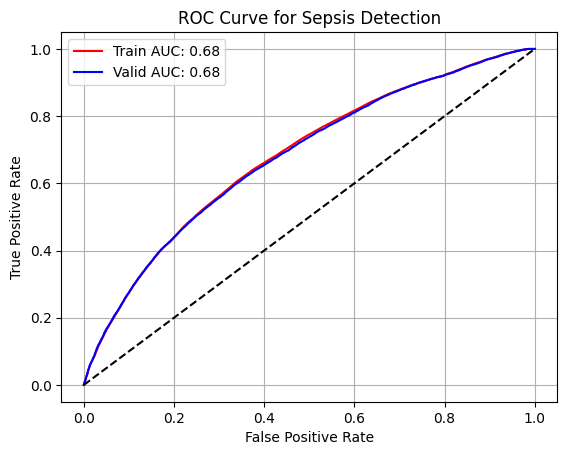

In [66]:
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_preds)
fpr_valid, tpr_valid, _ = roc_curve(y_test, y_test_preds)

plt.plot(fpr_train, tpr_train, 'r-', label='Train AUC: %.2f' % auc_train)
plt.plot(fpr_valid, tpr_valid, 'b-', label='Valid AUC: %.2f' % auc_valid)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC Curve for Sepsis Detection')
plt.grid(True)
plt.show()


In [67]:
y_train_preds = model2.predict(X_train2).flatten()
y_test_preds = model2.predict(X_test2).flatten()


586/586 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [68]:


# AUC
auc_train = roc_auc_score(y_train2, y_train_preds)
auc_valid = roc_auc_score(y_test2, y_test_preds)

print('Train AUC:%.3f' % auc_train)
print('Valid AUC:%.3f' % auc_valid)

# Other metrics
print('Train accuracy:%.3f' % calc_accuracy(y_train2, y_train_preds, thresh))
print('Valid accuracy:%.3f' % calc_accuracy(y_test2, y_test_preds, thresh))

print('Train recall:%.3f' % calc_recall(y_train2, y_train_preds, thresh))
print('Valid recall:%.3f' % calc_recall(y_test2, y_test_preds, thresh))

print('Train precision:%.3f' % calc_precision(y_train2, y_train_preds, thresh))
print('Valid precision:%.3f' % calc_precision(y_test2, y_test_preds, thresh))

print('Train specificity:%.3f' % calc_specificity(y_train2, y_train_preds, thresh))
print('Valid specificity:%.3f' % calc_specificity(y_test2, y_test_preds, thresh))

print('Train prevalence:%.3f' % calc_prevalence(y_train2))
print('Valid prevalence:%.3f' % calc_prevalence(y_test2))


Train AUC:0.766
Valid AUC:0.761
Train accuracy:0.703
Valid accuracy:0.705
Train recall:0.625
Valid recall:0.640
Train precision:0.717
Valid precision:0.707
Train specificity:0.774
Valid specificity:0.763
Train prevalence:0.478
Valid prevalence:0.472


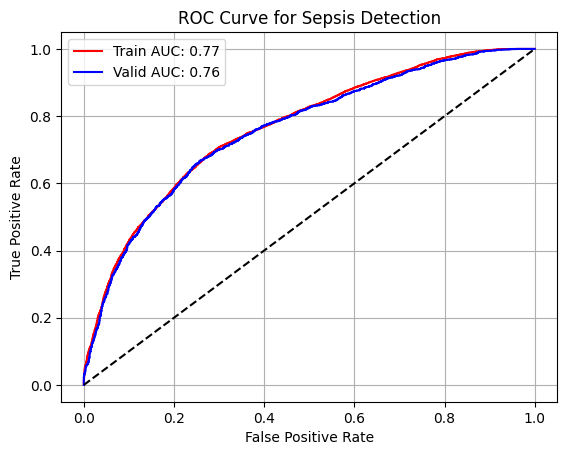

In [69]:
fpr_train, tpr_train, _ = roc_curve(y_train2, y_train_preds)
fpr_valid, tpr_valid, _ = roc_curve(y_test2, y_test_preds)

plt.plot(fpr_train, tpr_train, 'r-', label='Train AUC: %.2f' % auc_train)
plt.plot(fpr_valid, tpr_valid, 'b-', label='Valid AUC: %.2f' % auc_valid)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC Curve for Sepsis Detection')
plt.grid(True)
plt.show()
